In [243]:
# Disable warnings
import warnings
warnings.filterwarnings("ignore")

# Import libraries
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import dates

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [2]:
# Loading data and displaying the first 5 rows

df = pd.read_csv('NSE-TATAGLOBAL.csv')
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [3]:
# Checking the dataset for duplicate rows

print('Number of duplicate rows - ', len(df[df.duplicated()].values)) 

Number of duplicate rows -  0


In [4]:
# Checking the number of rows, data types and the absence of missing values

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2035 non-null   object 
 1   Open                  2035 non-null   float64
 2   High                  2035 non-null   float64
 3   Low                   2035 non-null   float64
 4   Last                  2035 non-null   float64
 5   Close                 2035 non-null   float64
 6   Total Trade Quantity  2035 non-null   int64  
 7   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 127.3+ KB


In [5]:
# Convert Date to datatime format and sort by date

df.Date = pd.to_datetime(df.Date, dayfirst=True)
df = df.sort_values('Date', ascending=True)
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56
2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98


In [6]:
# Will build the model for the price of stocks at the close of trading

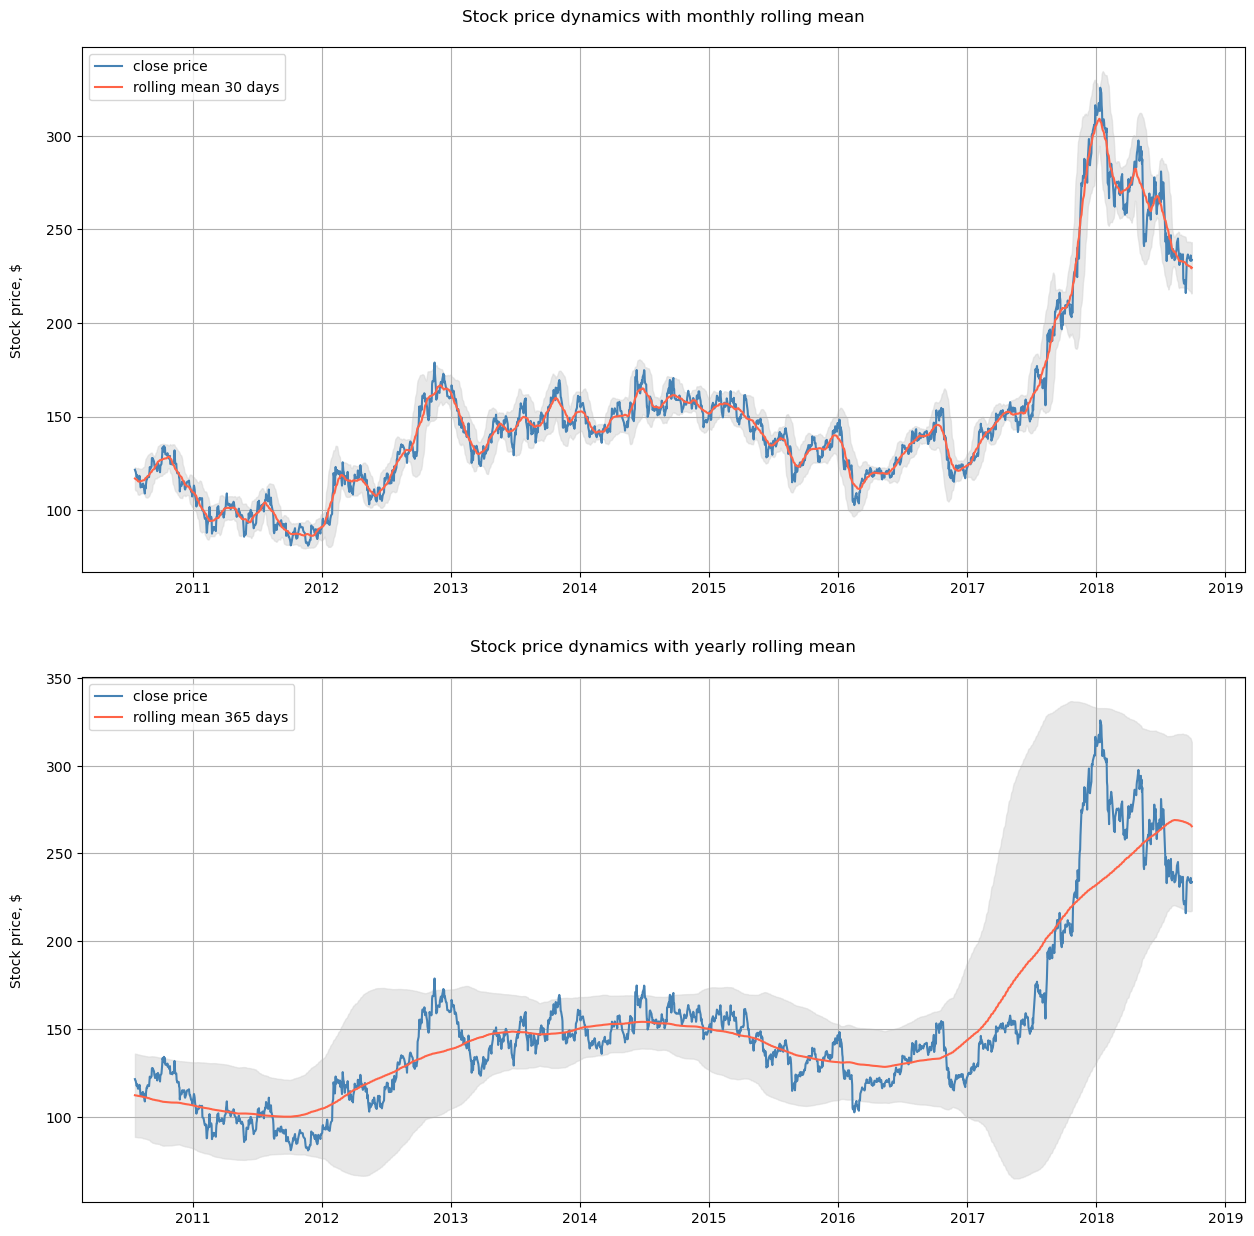

In [7]:
# Display graphs of the dynamics of the stock price, as well as a rolling mean with a month and year window and Bollinger 
# bands with 95% confidence interval

ts = df[['Date', 'Close']].rename(columns={'Close': 'Close price'}).set_index('Date').squeeze()

rolling_mean_month = ts.rolling(window=30, center=True, min_periods=15).mean()    
rolling_std_month = ts.rolling(window=30, center=True, min_periods=15).std()
lower_bound_month = rolling_mean_month - (1.96 * rolling_std_month)
upper_bound_month = rolling_mean_month + (1.96 * rolling_std_month)

rolling_mean_year = ts.rolling(window=365, center=True, min_periods=182).mean()    
rolling_std_year = ts.rolling(window=365, center=True, min_periods=182).std()
lower_bound_year = rolling_mean_year - (1.96 * rolling_std_year)
upper_bound_year = rolling_mean_year + (1.96 * rolling_std_year)

fig, ax = plt.subplots(2, 1, figsize=(15, 15))

ax[0].plot(ts, label='close price', color='steelblue')
ax[0].plot(rolling_mean_month, 'g', label='rolling mean 30 days', color='tomato')
ax[0].fill_between(x=ts.index, y1=lower_bound_month, y2=upper_bound_month, color='lightgrey', alpha=0.5)
ax[0].legend(loc='upper left')
ax[0].set_title('Stock price dynamics with monthly rolling mean\n')
ax[0].set_ylabel('Stock price, $\n')
ax[0].xaxis.set_major_locator(dates.AutoDateLocator())  
ax[0].grid()

ax[1].plot(ts, label='close price', color='steelblue')
ax[1].plot(rolling_mean_year, 'g', label='rolling mean 365 days', color='tomato')
ax[1].fill_between(x=ts.index, y1=lower_bound_year, y2=upper_bound_year, color='lightgrey', alpha=0.5)
ax[1].legend(loc='upper left')
ax[1].set_title('Stock price dynamics with yearly rolling mean\n')
ax[1].set_ylabel('Stock price, $\n')
ax[1].xaxis.set_major_locator(dates.AutoDateLocator())
ax[1].grid();

In [8]:
# Put historical data for the model in a separate dataframe

analysis_df = df[['Date', 'Close']].rename(columns={'Close': 'Close price'}).reset_index().drop(columns='index')

In [10]:
# Create a numpy array for the stock price column at the close of trading

close_price = analysis_df['Close price'].to_numpy().reshape(-1, 1)

In [12]:
# Normalizing data with MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(close_price)
close_price_scaled = scaler.transform(close_price)

In [255]:
# Set the date of separation of historical data into training and test ones and the length of the sequences for the formation 
# of arrays fed to the input of the model

len_sqn = 100
split_date = '2018-01-01'

# Determining the index corresponding to the selected date
split_index = analysis_df[analysis_df.iloc[:,0]==split_date].index[0]

In [256]:
# Creating function to form an array contains sequences of length len_sqn with an offset of 1 day (more precisely, 1 date from 
# the time series, since not all days in a row are present in the series)

def to_sequences(data, raw_len):
    sqn_list = []
    for index in range(len(data) - raw_len):
        sqn_list.append(data[index: index + raw_len])
    return np.array(sqn_list)

# Creation a function for splitting on training and test samples. The input is a 1d array of stock price values, the length 
# of the sequences, and the date of division into a train/test. Output: dataset divided into training and test samples as 
# numpy arrays, where X_train, X_test are sets of sequences of length len_sqn-1, and y_train, y_test are an array of the last 
# values of each of the received sequences.

def preprocessing(data_1d_array, raw_len, index):
    data = to_sequences(data_1d_array, raw_len)
    X_train = data[:index, :-1, :]
    y_train = data[:index, -1, :]
    X_test = data[index:, :-1, :]
    y_test = data[index:, -1, :]
    return X_train, y_train, X_test, y_test

train_x, train_y, test_x, test_y = preprocessing(close_price_scaled, len_sqn, split_index)

In [265]:
# Building and compiling a model with 4 LSTM and Dense layers. Use dropout layers after each LSTM layer to reduce overfitting.
# Take MSE as a loss function.

windows_size = len_sqn - 1

model = Sequential()
model.add(LSTM(windows_size, return_sequences=True, input_shape=(windows_size, train_x.shape[-1])))
model.add(Dropout(0.4))
model.add(LSTM(windows_size*2, return_sequences = True))
model.add(Dropout(0.4))
model.add(LSTM(windows_size*2, return_sequences = True))
model.add(Dropout(0.4))
model.add(LSTM(windows_size))
model.add(Dropout(0.6))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')

In [266]:
# Fit model on 70 epochs with a batch size of 32.

history = model.fit(train_x, train_y, epochs=70, batch_size=32, validation_split=0.1)

Epoch 1/70
53/53 [==============================] - 6s 54ms/step - loss: 0.0051 - val_loss: 0.0333
Epoch 2/70
53/53 [==============================] - 2s 36ms/step - loss: 0.0024 - val_loss: 0.0200
Epoch 3/70
53/53 [==============================] - 2s 36ms/step - loss: 0.0022 - val_loss: 0.0210
Epoch 4/70
53/53 [==============================] - 2s 36ms/step - loss: 0.0018 - val_loss: 0.0190
Epoch 5/70
53/53 [==============================] - 2s 36ms/step - loss: 0.0020 - val_loss: 0.0221
Epoch 6/70
53/53 [==============================] - 2s 36ms/step - loss: 0.0017 - val_loss: 0.0250
Epoch 7/70
53/53 [==============================] - 2s 36ms/step - loss: 0.0015 - val_loss: 0.0243
Epoch 8/70
53/53 [==============================] - 2s 36ms/step - loss: 0.0016 - val_loss: 0.0066
Epoch 9/70
53/53 [==============================] - 2s 37ms/step - loss: 0.0014 - val_loss: 0.0204
Epoch 10/70
53/53 [==============================] - 2s 36ms/step - loss: 0.0012 - val_loss: 0.0266
Epoch 11/

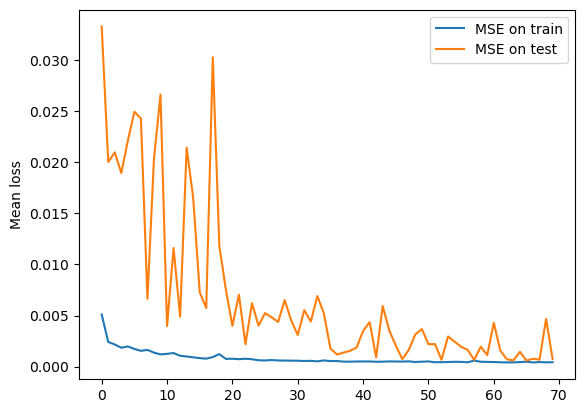

In [267]:
# Learning history visualization

plt.plot(history.history['loss'], label='MSE on train')
plt.plot(history.history['val_loss'], label='MSE on test')
plt.ylabel('Mean loss')
plt.legend(loc='upper right')
plt.show()

In [268]:
# Make a prediction for the test sample

pred_y = model.predict(test_x)

3/3 [==============================] - 1s 20ms/step


In [269]:
# Performing an inverse transformation of the predicted and test values

inversed_test_y = scaler.inverse_transform(test_y)
inversed_pred_y = scaler.inverse_transform(pred_y)

In [270]:
# Get the root mean squared error (RMSE)

rmse = mean_squared_error(inversed_test_y, inversed_pred_y, squared=False)
rmse

6.435103230500199

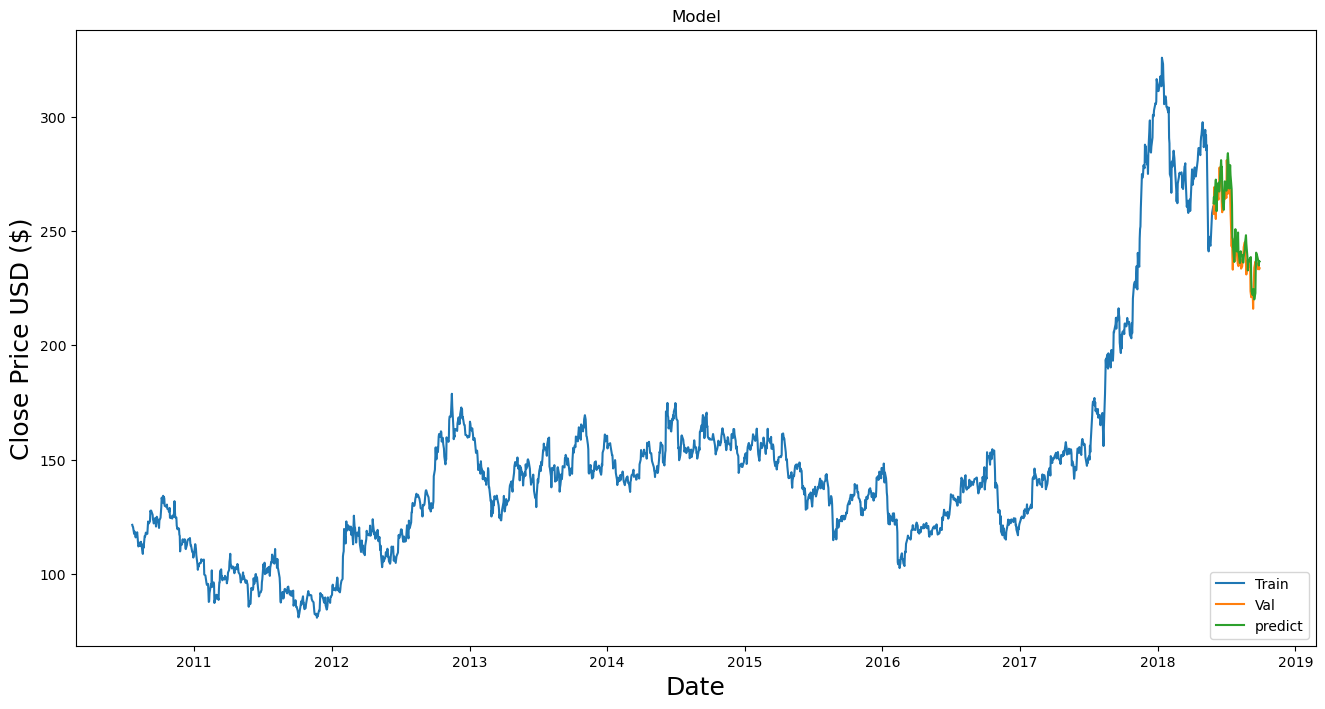

In [271]:
# Visualize the historycal and prediction data

train = analysis_df[:(split_index+100)].set_index('Date')
valid = analysis_df[(split_index+100):].set_index('Date')
valid['predict'] = inversed_pred_y

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close price'])
plt.plot(valid[['Close price', 'predict']])
plt.legend(['Train', 'Val', 'predict'], loc='lower right')
plt.show()